In [1]:
import polars as pl
import spacy

In [2]:
metadata = pl.read_parquet('../../data/google/production/metadata.parquet')
nlp = spacy.load('en_core_web_lg')

In [3]:
def count_categories(column):
    categories = {}
    for value in column:
        try:
            value = [x.strip() for x in value.split(',')]
        except:
            continue
        for x in value:
            if x not in categories:
                categories[x] = 1
            else:
                categories[x] += 1
    return categories

In [4]:
categories = count_categories(metadata['category'])
index_category = list(categories.keys())

In [5]:
# categ2vec es un diccionario de la forma key (categoria) : value (vector)
categ2vec = {}
for categ in categories.keys():
    vector = nlp(categ).vector
    categ2vec[categ] = vector

In [6]:
# Importamos la libreria para crear los clusteres
from sklearn.cluster import KMeans

# Cargamos la funcion de similitud para evaluar los clusteres
from sklearn.metrics.pairwise import cosine_similarity

# Importamos numpy para trabajar con matrices
import numpy as np

In [7]:
# Se crea una matriz donde cada fila es el vector de las categoria.
data = np.vstack(list(categ2vec.values()))
# Se computa la matriz de similitud, por lo que es de 1312 x 1312
sim_data = cosine_similarity(data)

# Numero de filas/columnas
data.shape, sim_data.shape

((4469, 300), (4469, 4469))

In [8]:
# Funcion que utilizamos para evaluar el numero de cluster
def mean_similarity(index):
    # medida de cohesion o similitud.
    output = []
    for i in range(len(index)):
        for j in range(i+1, len(index)):
            similarity = sim_data[index[i], index[j]]
            output.append(similarity)
    return np.mean(output)

In [9]:
# Lista que contendra el valor de la metrica para el numero de cluster dados
metrics = []
for i in range(5, 30):
    # Creamos el modelo con los parametros determinados
    model = KMeans(n_clusters=i, random_state=2023, n_init=5, init='k-means++')
    # Entrenamos el modelo y obtenemos los labels
    model.fit(data)
    cluster_labels = model.labels_

    # Agrupamos las categorias en los grupos correspondientes
    group = {}
    sim_by_group = []
    for label in set(cluster_labels):
        if label == -1:
            continue
        index = np.where(cluster_labels == label)[0]
        elements = [index_category[i] for i in index]
        group[label] = elements
        sim_by_group.append(len(index) * mean_similarity(index))
    metrics.append(np.sum(sim_by_group) / len(cluster_labels))

# Esta lista contiene la variacion en la metrica
variacion = []
for i in range(1, len(metrics)):
    value = np.round((metrics[i] - metrics[i - 1]) / metrics[i - 1], 3)
    variacion.append(value)

In [10]:
# Importamos la libreria para poder graficar la matrica
import matplotlib.pyplot as plt

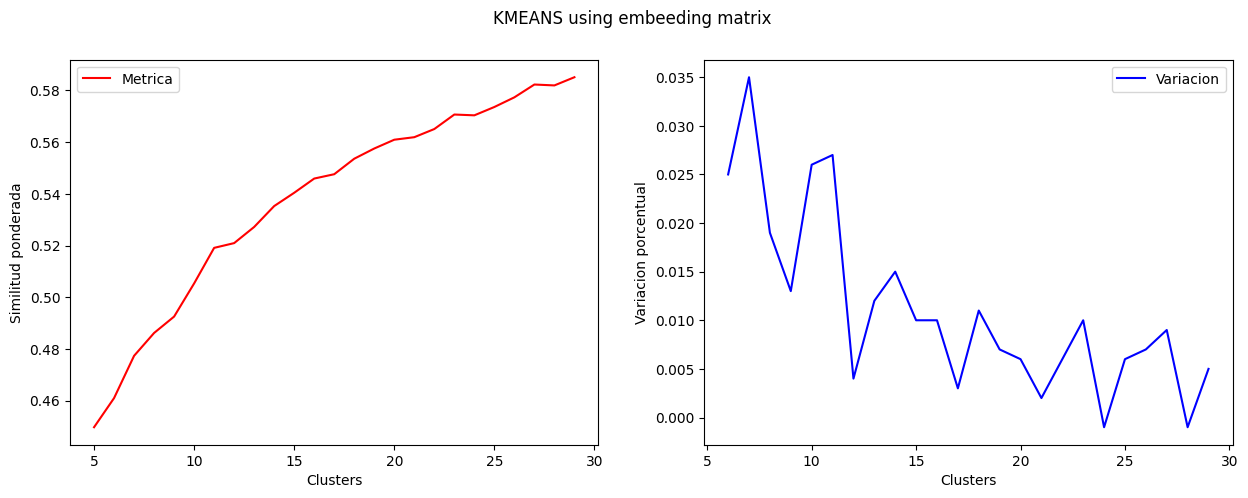

In [11]:
# Graficamos la metrica y la variacion.

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(5, 30), metrics, color='r', label='Metrica')
ax[1].plot(range(6, 30), variacion, color='b', label='Variacion')

fig.suptitle('KMEANS using embeeding matrix')
ax[0].set_xlabel('Clusters')
ax[1].set_xlabel('Clusters')

ax[0].set_ylabel('Similitud ponderada')
ax[1].set_ylabel('Variacion porcentual')

ax[0].legend()
ax[1].legend()

# fig.savefig('kmeans_v1')

plt.show()

In [12]:
# Elegimos el numero de cluster que vamos a usar basandonos en el grafico de arriba
# Y printamos unos ejemplos para ver como son.

model = KMeans(n_clusters=12, random_state=2023, init='k-means++', n_init=5)
model.fit(data)
cluster_labels = model.labels_

group = {}

for label in set(cluster_labels):
    if label == -1:
        continue
    index = np.where(cluster_labels == label)[0]
    elements = [index_category[i] for i in index]
    print(f'Group {label}: {elements[0:5]}')
    group[str(label)] = elements

Group 0: ['public safety office', 'training centre', 'engineering consultant', 'conference center', 'title company']
Group 1: ['greeting card shop', 'paint store', 'convenience store', 'auto repair shop', 'toy store']
Group 2: ['waxing hair removal service', 'service establishment', 'wheelchair rental service', 'security guard service', 'business to business service']
Group 3: ['church', 'public swimming pool', 'swimming', 'mountain peak', 'lutheran church']
Group 4: ['place of worship', 'state department of transportation', 'church of the nazarene', 'church of christ', 'united church of christ']
Group 5: ['country club', 'soccer club', 'gym', 'football club', 'bicycle club']
Group 6: ['paint manufacturer', 'medical supply store', 'water softening equipment supplier', 'auto accessories wholesaler', 'propane supplier']
Group 7: ['nail salon', 'hair salon', 'jeweler', 'florist', 'garbage dump']
Group 8: ['jewelry designer', 'photographer', 'internist', 'musical instrument repair shop', '

In [13]:
# Aqui creamos las etiquetas con las que agruparemos cada una de las viejas categorias.

new_labels =["business services", "retail stores", "service establishments", "places of interest and worship", "places of interest and worship",
             "clubs and sports", "wholesale suppliers", "personal care services", "creative professionals", "healthcare services",
             "food and beverage establishments", "educational institutions"]

new_labels = {str(key):label for key, label in enumerate(new_labels)}

new_group = {}
for key, value in group.items():
    label = new_labels[key]
    if label not in new_group:
        new_group[label] = value
    else:
        new_group[label].extend(value)

In [14]:
# Toca crear una nueva columna tal que tenga la etiqueta correspondiente segun el grupo al que pertenezca.
# Esta funcion hace lo de arriba
def add_label(categories):
    try:
        categories = [x.strip() for x in categories.split(',')]
    except:
        return None
    for category in categories:
        for key, value in new_group.items():
            if category in value:
                return key

In [15]:
# Creamos la nueva columna llamada agg_categories
metadata = metadata.with_columns(pl.col('category').apply(add_label).alias('agg_categories'))

In [16]:
# Obtenemos la distribucion de datos para imputar los valores faltantes
counts = metadata.filter(pl.col('agg_categories').is_not_null())['agg_categories'].value_counts()['counts'].to_list()
# Y las etiquetas
labels = metadata.filter(pl.col('agg_categories').is_not_null())['agg_categories'].value_counts()['agg_categories'].to_list()

# Array de probabilidad
prob = np.array(counts)/np.sum(counts)

def get_random_labels(value, labels=labels, prob=prob):
    return np.random.choice(labels, size=1, p=prob)[0]

def fillna_partial_solution(value, function=get_random_labels):
    if value is not None:
        return value
    else:
        return function(value)

In [17]:
# Hacemos todo esto porque polars nos la pone re dificil compaaa
df = metadata.to_pandas()
df['agg_categories'] = df['agg_categories'].apply(fillna_partial_solution)

In [22]:
# Cantidad de nulos
print('ANTES:', metadata['agg_categories'].null_count())
metadata = pl.from_dataframe(df)
print('DESPUES:', metadata['agg_categories'].null_count())

ANTES: 17181
DESPUES: 0


In [24]:
# Almacenamos en formato parquet para reducir espacio.
metadata.write_parquet('../../data/google/production/metadata.parquet')